In [71]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [116]:
data_dir = "./data/train/"

# IMG_SIZE = 60
# BATCH_SIZE = 32

In [190]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [191]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


2023-06-02 20:59:11.950290: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


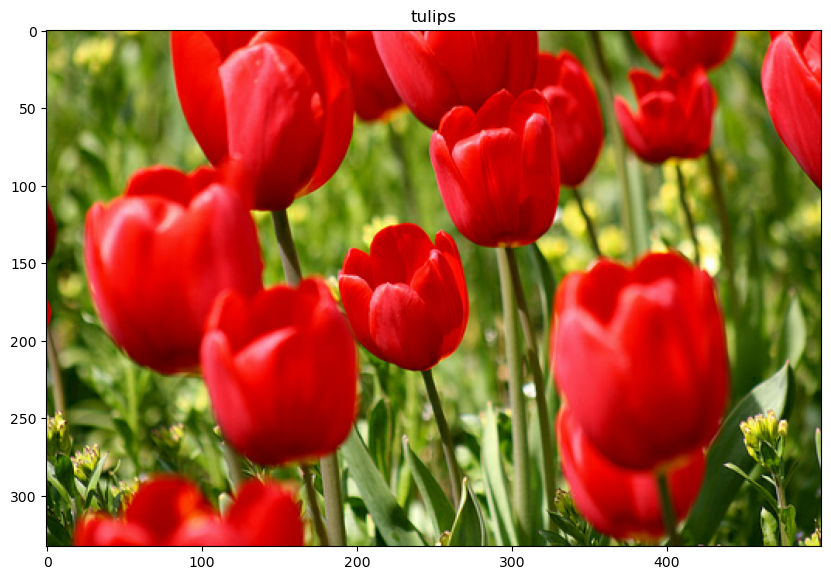

In [192]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
plt.figure(figsize=(10, 10))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

### Resizing and rescaling

In [193]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

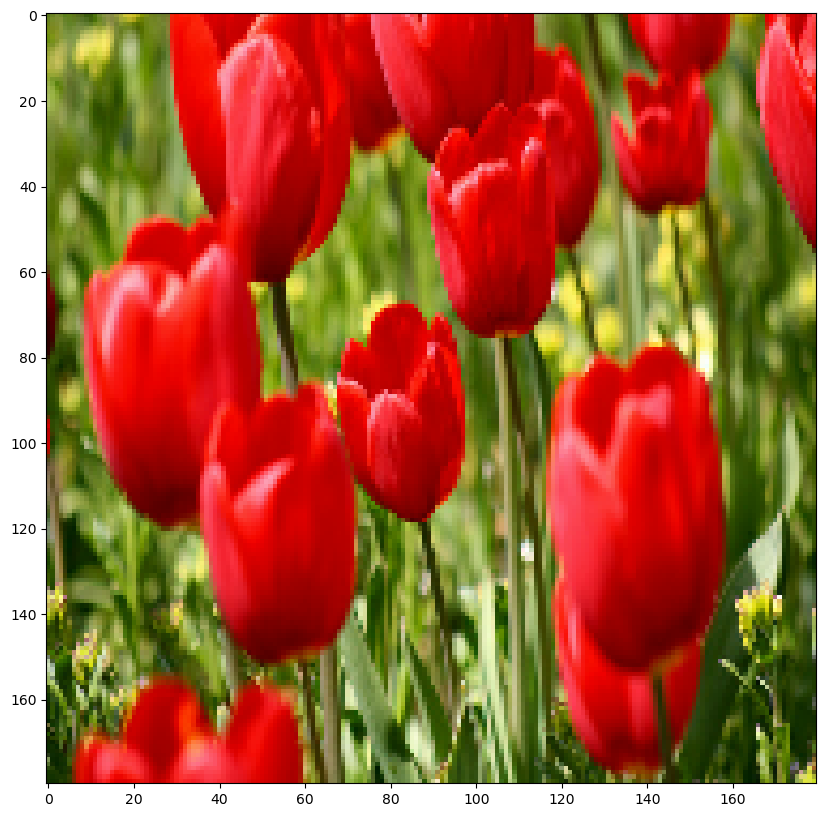

In [194]:
result = resize_and_rescale(image)
plt.figure(figsize=(10, 10))
_ = plt.imshow(result)

In [195]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

In [196]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# data_augmentation = tf.keras.Sequential(
#     [
#         layers.RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1),
#     ]
# )

In [197]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)


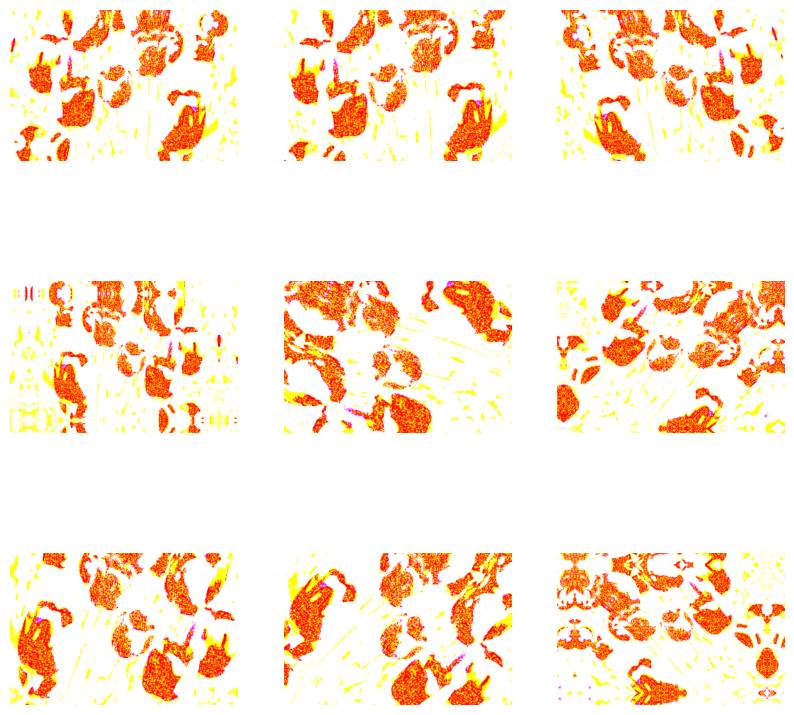

In [198]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [199]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [203]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_39 (Sequential)  (180, 180, 3)             0         
                                                                 
 sequential_40 (Sequential)  (1, 333, 500, 3)          0         
                                                                 
 conv2d_15 (Conv2D)          multiple                  0 (unused)
                                                                 
 max_pooling2d_15 (MaxPooli  multiple                  0 (unused)
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          multiple                  0 (unused)
                                                                 
 max_pooling2d_16 (MaxPooli  multiple                  0 (unused)
 ng2D)                                               

In [202]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [201]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


ValueError: in user code:

    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_41' (type Sequential).
    
    Input 0 of layer "conv2d_15" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (180, 180, 3)
    
    Call arguments received by layer 'sequential_41' (type Sequential):
      • inputs=tf.Tensor(shape=(None, None, 3), dtype=uint8)
      • training=True
      • mask=None


In [106]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

ValueError: in user code:

    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1850, in test_step
        y_pred = self(x, training=False)
    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/csantana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_9' (type Sequential).
    
    Input 0 of layer "conv2d_8" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (180, 180, 3)
    
    Call arguments received by layer 'sequential_9' (type Sequential):
      • inputs=tf.Tensor(shape=(None, None, 3), dtype=uint8)
      • training=False
      • mask=None
